## In this notebook

- xG model.

In [1]:
from pathlib import Path

# data wrangling
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

# plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# modelling
from scipy.ndimage import gaussian_filter 
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    auc,
    brier_score_loss,
    mean_absolute_percentage_error, 
    log_loss,
    roc_auc_score, 
    roc_curve,
)
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

# utils
from utils import UHC_PLAYERS

# other
from tqdm.notebook import tqdm

In [2]:
DATA_FOLDER_PATH = Path("/usr/src/app/data/")

DATA_FILE_NAME_SHOTS = "shots_after_eda.parquet"
DATA_FILE_NAME_PLAYERS = "players.parquet"

## Read data

In [3]:
# shots

df = pd.read_parquet(DATA_FOLDER_PATH / DATA_FILE_NAME_SHOTS)
df.tail()

,game_id,game_date,away_team_id,home_team_id,period,period_type,time_in_period,situation_code,home_team_defending_side,event_type,sort_order,x_coord,y_coord,zone_code,event_owner_team_id,shot_type,shooting_player_id,goalie_in_net_id,season,x_coord_norm,y_coord_norm,distance_from_goal,angle,zone,second,time_between_shots,season_type,home_players_in_box,away_players_in_box,home_players_on_ice,away_players_on_ice,strength,coords_combination,coords_strength_combination,is_empty_net,is_rebound,is_goal
435181,2021021132,2022-04-07,55,16,3,REG,13:33,1451,right,missed-shot,564,-51,-17,O,16.0,wrist,8477495,8475831.0,2021,51,17,41.629317,24.102235,circle,3213,49.0,2,0.0,1.0,5,4,5v4,"51,17","51,17,5v4",0,0,0
435182,2021021132,2022-04-07,55,16,3,REG,14:31,1551,right,shot-on-goal,574,-37,-32,O,16.0,wrist,8475177,8475831.0,2021,37,32,61.057350,31.607502,blue line,3271,58.0,2,0.0,0.0,5,5,5v5,"37,32","37,32,5v5",0,0,0
435183,2021021132,2022-04-07,55,16,3,REG,19:30,1560,right,missed-shot,622,-69,0,O,16.0,tip-in,8478440,8475831.0,2021,69,0,20.000000,0.000000,high slot,3570,11.0,2,0.0,0.0,5,5,5v5,"69,0","69,0,5v5",0,0,0
435184,2021021133,2022-04-07,10,25,1,REG,02:20,1551,right,shot-on-goal,35,-34,23,O,25.0,wrist,8480036,8475789.0,2021,34,-23,59.615434,22.693795,blue line,140,14.0,2,0.0,0.0,5,5,5v5,"34,-23","34,-23,5v5",0,0,0
435185,2021021133,2022-04-07,10,25,1,REG,03:04,1551,right,shot-on-goal,42,67,27,O,10.0,wrist,8479318,8475809.0,2021,67,27,34.828150,50.826342,circle,184,32.0,2,0.0,0.0,5,5,5v5,"67,27","67,27,5v5",0,0,0


In [4]:
# players - Utah HC only

df_players = pd.read_parquet(DATA_FOLDER_PATH / DATA_FILE_NAME_PLAYERS)
df_players.tail()

,player_id,full_name,position_code,season_long,season_type,team_full_name,games_played
88,8481711,Matias Maccelli,L,2023/2024,2,Arizona Coyotes,82
89,8482659,Josh Doan,R,2023/2024,2,Arizona Coyotes,11
90,8482699,Dylan Guenther,R,2022/2023,2,Arizona Coyotes,33
91,8482699,Dylan Guenther,R,2023/2024,2,Arizona Coyotes,45
92,8483431,Logan Cooley,C,2023/2024,2,Arizona Coyotes,82


## Build an xG model

In [5]:
def get_df_per_game_stats(df: pd.DataFrame, preds_col: str) -> pd.DataFrame:
    return (
        df
        .groupby(by=["game_id"])
        .agg(
            goals_cnt=("is_goal", "sum"),
            xgoals_cnt=(preds_col, "sum"),
        )
    )

def evaluate_model_performance(
    df: pd.DataFrame, 
    df_per_game_stats: pd.DataFrame, 
    preds_col: str
) -> None:
    roc_auc = roc_auc_score(y_true=df.is_goal, y_score=df[preds_col])
    loss = log_loss(y_true=df.is_goal, y_pred=df[preds_col])
    brier = brier_score_loss(y_true=df.is_goal, y_prob=df[preds_col])
    mape_per_game = mean_absolute_percentage_error(
        y_true=df_per_game_stats.loc[df_per_game_stats.goals_cnt > 0].goals_cnt, 
        y_pred=df_per_game_stats.loc[df_per_game_stats.goals_cnt > 0].xgoals_cnt,
    )
    
    print(f"ROC AUC score: {roc_auc:,.3f}")
    print(f"Log loss: {loss:,.3f}")
    print(f"Brier loss: {brier:,.3f}")
    print(f"MAPE score (per game): {mape_per_game:,.3f}")

In [6]:
def get_filtered_players(df: pd.DataFrame, lower_q: float = 0.00, upper_q: float = 1.00) -> pd.Series:
    """Get list of players, filtered by number of shots.
    
    The idea behind this exercise is to filter out outliers that can have a negative impact on the xG model.
    """
    df_players_shots_stats = (
        df
        .groupby(by=["shooting_player_id"])
        .agg(
            seasons_cnt=("season", "nunique"),
            shots_cnt=("game_id", "count"),
            unique_games_cnt=("game_id", "nunique"),
        )
        .reset_index()
    )

    shots_lower_q = df_players_shots_stats.shots_cnt.quantile(lower_q)
    shots_upper_q = df_players_shots_stats.shots_cnt.quantile(upper_q)

    df_players_filtered = (
        df_players_shots_stats
        .query(f"{shots_lower_q} < shots_cnt < {shots_upper_q}")
    )
    
    print(f"- all players count: {df.shooting_player_id.nunique():,.0f}")
    print(f"- filtered players count: {df_players_filtered.shooting_player_id.nunique():,.0f}")

    df_filtered_shots = df.loc[df.shooting_player_id.isin(df_players_filtered.shooting_player_id)]
    print(f"- all shots count: {len(df):,.0f}")
    print(f"- filtered shots count: {len(df_filtered_shots):,.0f}")
    
    return df_players_filtered.shooting_player_id


filtered_players = get_filtered_players(df=df, lower_q=.05)

- all players count: 1,322
- filtered players count: 1,231
- all shots count: 435,186
- filtered shots count: 433,036


#### 1) Baseline probability model

Probability of goal per every X/Y coordinates combination.

In [7]:
# create model

# minimal number of shots to consider the coordinates combination
MIN_SHOTS_CNT = 10

model_1 = (
    df
    .loc[df.shooting_player_id.isin(filtered_players)]
    .groupby(by=["coords_combination"])
    
    # compute xG value per every coordinates combination
    .agg(
        shots_cnt=("event_type", "count"),
        goals_cnt=("event_type", lambda x: x.eq("goal").sum()),
        xg=("event_type", lambda x: x.eq("goal").mean()),
    )
    
    # filter out rows with insignificant value
    .query(f"shots_cnt > {MIN_SHOTS_CNT}")
    
    # save coordinates to xG value mapping
    .xg.to_dict()
)

In [8]:
# evaluate model performance

preds_col = "model_1_preds"
df[preds_col] = df.coords_combination.map(model_1).fillna(0)

df_per_game_stats = get_df_per_game_stats(df=df, preds_col=preds_col)
evaluate_model_performance(df=df, df_per_game_stats=df_per_game_stats, preds_col=preds_col)

ROC AUC score: 0.738
Log loss: 0.256
Brier loss: 0.063
MAPE score (per game): 0.413


#### 2) Probability model per every strength type (equal strengths, PP, SH)

Probability of goal per every X/Y coordinates combination, and strength state.

In [9]:
# create model

# minimal number of shots to consider the coordinates combination
MIN_SHOTS_CNT = 3

model_2 = (
    df
    .loc[df.shooting_player_id.isin(filtered_players)]
    .groupby(by=["coords_strength_combination"])
    
    # compute xG value per every coordinates combination
    .agg(
        shots_cnt=("event_type", "count"),
        goals_cnt=("event_type", lambda x: x.eq("goal").sum()),
        xg=("event_type", lambda x: x.eq("goal").mean()),
    )
    
    # filter out rows with insignificant value
    .query(f"shots_cnt > {MIN_SHOTS_CNT}")
    
    # save coordinates to xG value mapping
    .xg.to_dict()
)

In [10]:
# evaluate model performance

preds_col = "model_2_preds"
df[preds_col] = df.coords_strength_combination.map(model_2).fillna(0)

df_per_game_stats = get_df_per_game_stats(df=df, preds_col=preds_col)
evaluate_model_performance(df=df, df_per_game_stats=df_per_game_stats, preds_col=preds_col)

ROC AUC score: 0.751
Log loss: 0.342
Brier loss: 0.062
MAPE score (per game): 0.395


#### 3) Combination of the two models above.

In [11]:
# evaluate model performance

preds_col = "model_3_preds"

df[preds_col] = df.coords_strength_combination.map(model_2).fillna(df.model_1_preds)

df_per_game_stats = get_df_per_game_stats(df=df, preds_col=preds_col)
evaluate_model_performance(df=df, df_per_game_stats=df_per_game_stats, preds_col=preds_col)

ROC AUC score: 0.770
Log loss: 0.233
Brier loss: 0.062
MAPE score (per game): 0.406


#### 4) ML based

In [12]:
numerical_columns = [
    "x_coord_norm",
    "y_coord_norm",
    "distance_from_goal",
    "angle",
    "period",
    "time_between_shots",
    "is_empty_net",
    "is_rebound",
]

categorical_columns = [
    "shot_type",
    "strength", 
    "zone",
]

In [13]:
# define column transformer

categorical_transformer = Pipeline(
    steps=[
        # ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")), 
        ("encoder", OneHotEncoder()),
    ]
)
numerical_transformer = Pipeline(
   steps=[
       # ("imputer", KNNImputer()),
       ("imputer", SimpleImputer(strategy="constant", fill_value=-1)),
       ("scaler", MinMaxScaler()),
   ]
)
column_transformer = ColumnTransformer(
   transformers=[
     ("numeric", numerical_transformer, numerical_columns),
     ("categorical", categorical_transformer, categorical_columns),
   ]
)

In [14]:
# define X and y columns

X_cols = [*numerical_columns, *categorical_columns]
y_col = "is_goal"

In [15]:
# fit a pipeline object on the whole data set

pipeline = Pipeline(
    steps=[
        ("column_transformer", column_transformer),
        # ("model", LogisticRegression(max_iter=10_000)),
        ("model", DecisionTreeClassifier(max_depth=18)),
        # ("model", KNeighborsClassifier()), 
        # ("model", GradientBoostingClassifier()), 
    ]
)

pipeline.fit(
    # X=df[X_cols],
    # y=df[y_col],
    X=df.loc[df.shooting_player_id.isin(filtered_players), X_cols], 
    y=df.loc[df.shooting_player_id.isin(filtered_players), y_col],
)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=-1,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['x_coord_norm',
                                                   'y_coord_norm',
                                                   'distance_from_goal',
                                                   'angle', 'period',
                                                   'time_between_shots',
                                                   'is_empty_net',
                                                   'is_rebound']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['shot_type', 'strength',
                                                   'zone'])])),
                ('model', DecisionTreeClassifier(max_depth=18))])

In [16]:
# evaluate model performance

preds_col = "model_4_preds"

df[preds_col] = pipeline.predict_proba(df[X_cols])[:, 1]

df_per_game_stats = get_df_per_game_stats(df=df, preds_col=preds_col)
evaluate_model_performance(df=df, df_per_game_stats=df_per_game_stats, preds_col=preds_col)

ROC AUC score: 0.869
Log loss: 0.181
Brier loss: 0.048
MAPE score (per game): 0.362


## xG model selection

Compare the performance of the models and choose the best one.

In [17]:
# prepare data

model_names = [str(i) for i in range(1, 5)]

log_losses = []
brier_losses = []

for model_name in model_names:
    log_losses.append(
        log_loss(y_true=df.is_goal, y_pred=df[f"model_{model_name}_preds"])
    )
    brier_losses.append(
        brier_score_loss(y_true=df.is_goal, y_prob=df[f"model_{model_name}_preds"])
    )

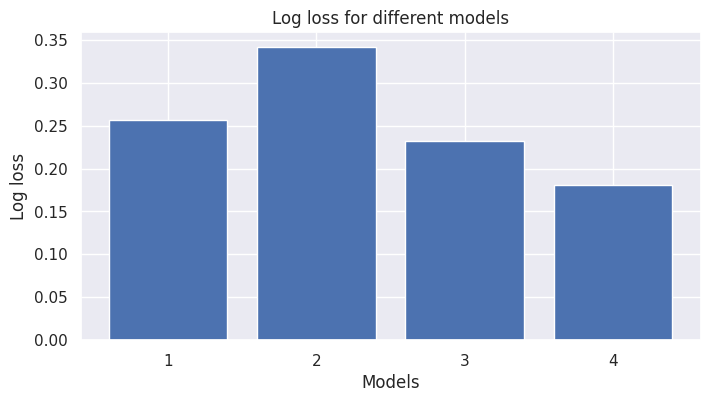

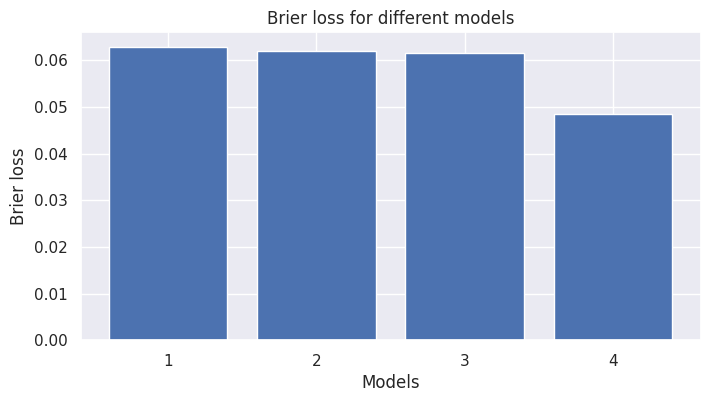

In [18]:
def plot_loss_comparison(vals: list, loss_name: str) -> None:    
    plt.figure(figsize=(8, 4))

    plt.bar(x=model_names, height=vals)
    plt.xlabel("Models")
    plt.ylabel(loss_name)
    plt.title(f"{loss_name} for different models")
    # plt.ylim(0, max(vals) * 1.1)  # Adding some space above the bars
    plt.show()
    
    
plot_loss_comparison(vals=log_losses, loss_name="Log loss")
plot_loss_comparison(vals=brier_losses, loss_name="Brier loss")

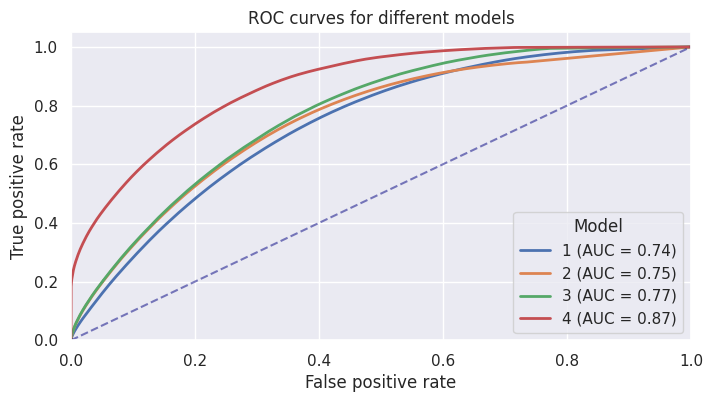

In [19]:
def plot_roc_comparison():
    plt.figure(figsize=(8, 4))

    for model_name in model_names:
        fpr, tpr, _ = roc_curve(y_true=df.is_goal, y_score=df[f"model_{model_name}_preds"])
        roc_auc = auc(x=fpr, y=tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {roc_auc:.2f})")

    # plot the diagonal line for random guessing
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--", alpha=0.5)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title("ROC curves for different models")
    plt.legend(loc="lower right", title="Model")
    plt.show()
    
    
plot_roc_comparison()

In [20]:
def get_auc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true=y_true, y_score=y_pred)
    return auc(x=fpr, y=tpr)


print(
    pd
    .DataFrame([
        {
            "Model": model_name,
            "Log Loss": log_loss(y_true=df.is_goal, y_pred=df[f"model_{model_name}_preds"]),
            "Brier Score": brier_score_loss(y_true=df.is_goal, y_prob=df[f"model_{model_name}_preds"]),
            "ROC AUC Score": get_auc(y_true=df.is_goal, y_pred=df[f"model_{model_name}_preds"]),
        }
        for model_name in model_names
    ])
    .round(3)
    .set_index("Model")
)

       Log Loss  Brier Score  ROC AUC Score
Model                                      
1         0.256        0.063          0.738
2         0.342        0.062          0.751
3         0.233        0.062          0.770
4         0.181        0.048          0.869


## Players analysis

In [21]:
MODEL_V = "model_4"
SEASON = 2023

#### Detect players who outperform/underperform relative to the xG

In [22]:
cols = [
    "full_name", "position_code", "games_played", "games_cnt",
    "shots_cnt", "shoot_perc", "g_cnt", "xg_cnt", "goe", "xg_conv"
]

players_general_info = df_players.drop_duplicates("player_id", keep="last").set_index("player_id")

players_stats = (
    df
    .loc[
        (df.shooting_player_id.isin(UHC_PLAYERS)) 
        & (df.season == SEASON)
    ]
    .groupby(by=["shooting_player_id"])
    .agg(
        games_cnt=("game_id", "nunique"),
        shots_cnt=("game_id", "count"),
        shoot_perc=("is_goal", "mean"),
        g_cnt=("is_goal", "sum"),
        xg_cnt=(f"{MODEL_V}_preds", "sum"),
    )
    
    # create "goals - expected goals" stat
    # (positive value = outperforming player; negative values = underperforming player)
    .assign(
        goe=lambda _df: (_df.g_cnt - _df.xg_cnt).round(2),
        xg_conv=lambda _df: _df.g_cnt.div(_df.xg_cnt).round(2),
        full_name=lambda _df: (_df.index.map(players_general_info.full_name)),
        position_code=lambda _df: (_df.index.map(players_general_info.position_code)),
        games_played=lambda _df: (_df.index.map(players_general_info.games_played)),
    )

    # remove players that didn't shoot in many games
    .query("games_cnt >= 10")
    
    # sort values
    .sort_values(by=["goe"], ascending=[False])
    
    # sort columns
    .loc[:, cols]
    
    # update types
    .astype({"games_played": "int"})
    .round(2)
)


players_stats

,full_name,position_code,games_played,games_cnt,shots_cnt,shoot_perc,g_cnt,xg_cnt,goe,xg_conv
shooting_player_id,,,,,,,,,,
8479343,Clayton Keller,R,78,78,323,0.10,31,22.60,8.40,1.37
8479619,Michael Carcone,L,74,59,152,0.14,21,12.87,8.13,1.63
8477951,Nick Schmaltz,C,79,75,240,0.09,21,18.19,2.81,1.15
8482699,Dylan Guenther,R,45,44,175,0.10,18,15.82,2.18,1.14
8480891,Michael Kesselring,D,65,57,134,0.04,5,2.84,2.16,1.76
8475760,Nick Bjugstad,C,76,69,235,0.09,21,19.03,1.97,1.10
8478474,Lawson Crouse,L,81,72,223,0.10,22,21.33,0.67,1.03
8478507,John Marino,D,75,52,81,0.05,4,3.81,0.19,1.05
8481711,Matias Maccelli,L,82,74,203,0.08,17,17.17,-0.17,0.99


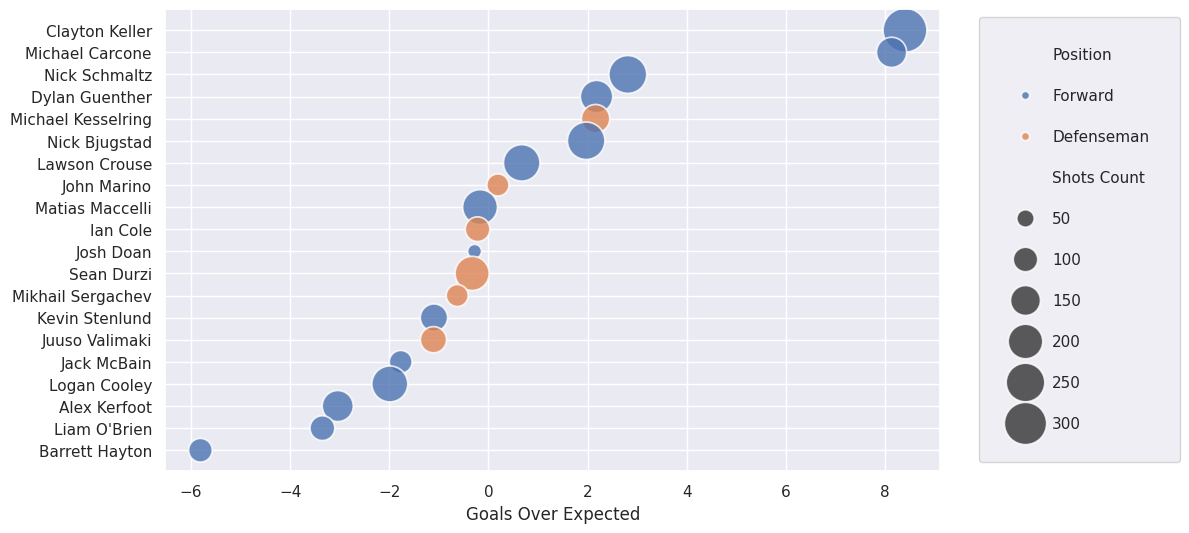

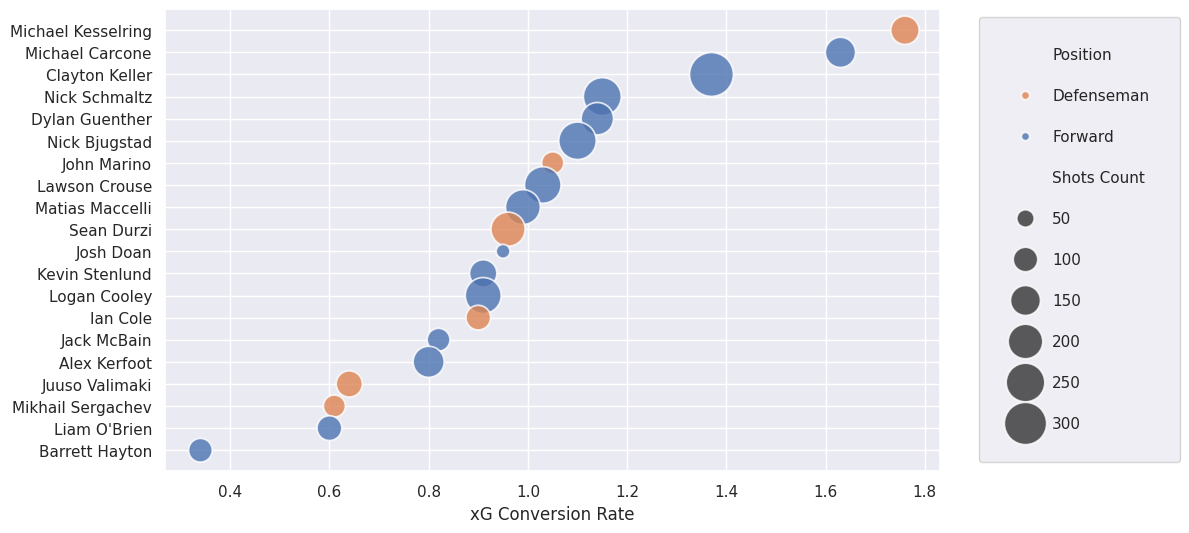

In [23]:
def plot_bubbles_per_team(col: str, label: str) -> None:

    plt.figure(figsize=(10, 6))

    pallete = {"Forward": "C0", "Defenseman": "C1"}

    sns.scatterplot(
        data=(
            players_stats
            .assign(
                position=lambda _df: np.where(_df.position_code == "D", "Defenseman", "Forward"),
            )
            .rename(columns={"shots_cnt": "Shots Count", "position": "Position"})
            .sort_values(by=col, ascending=False)
            .reset_index(drop=True)
        ),
        x=col,
        y="full_name",
        size="Shots Count",
        hue="Position",
        palette=pallete,
        # legend=False,
        sizes=(100, 1_000),
        alpha=0.8,
    )

    plt.xlabel(label)
    plt.ylabel("")
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", borderpad=2, labelspacing=1.7)

    # plt.tight_layout()
    plt.show()
    
    
plot_bubbles_per_team(col="goe", label="Goals Over Expected")
plot_bubbles_per_team(col="xg_conv", label="xG Conversion Rate")

#### Detect player form during the season

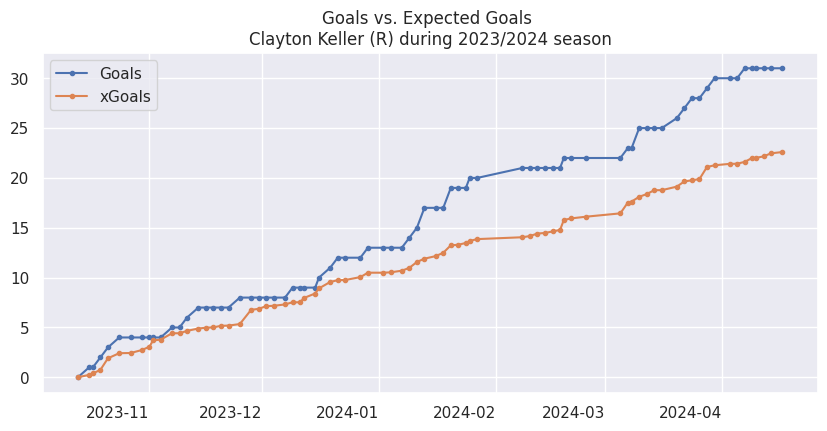

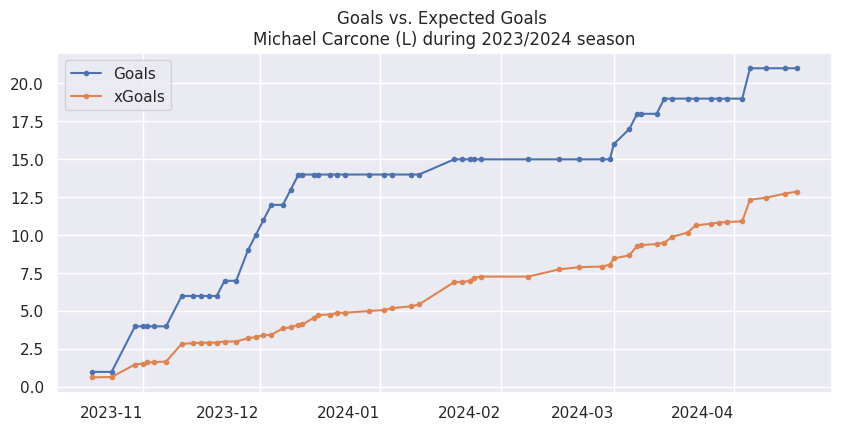

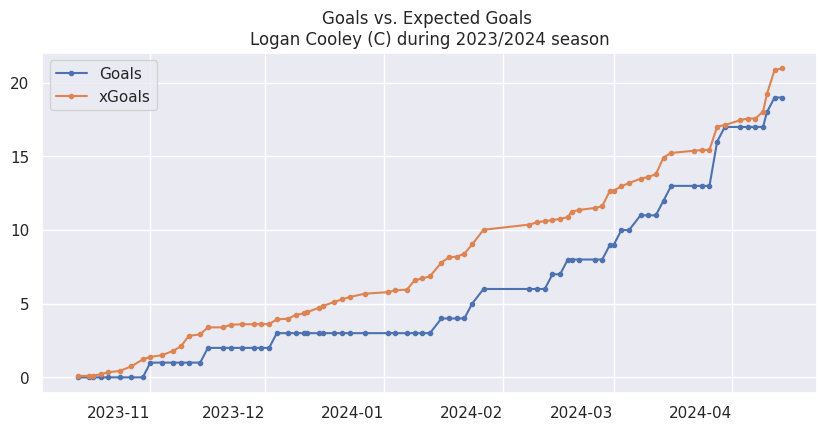

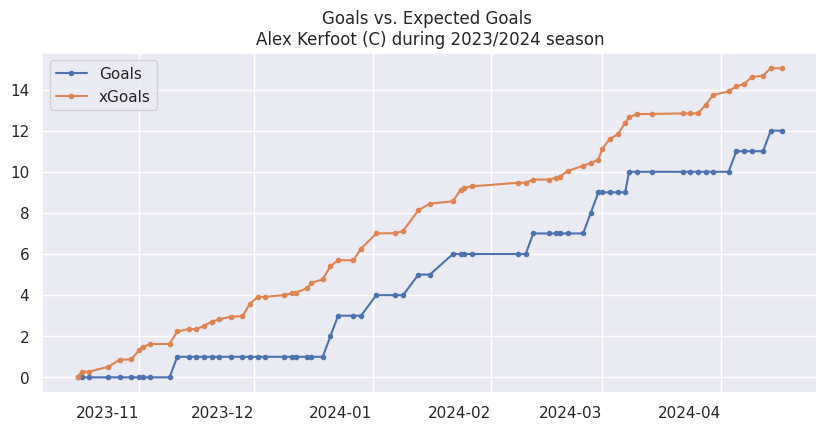

In [24]:
def plot_player_form_during_season(player_id: int, season: int) -> None:
    player_info = players_general_info.loc[player_id]
    
    ax = (
        df
        .loc[(df.shooting_player_id == player_id) & (df.season == season)]
        .groupby(by=pd.to_datetime(df.game_date))
        # .groupby(by="game_id")
        .agg(
            g_cnt=("is_goal", "sum"),
            xg_cnt=(f"{MODEL_V}_preds", "sum"),
        )
        .sort_index()
        .cumsum()
        .rename(columns={"g_cnt": "Goals", "xg_cnt": "xGoals"})
        .plot(
            figsize=(10, 5),
            rot=0,
            title=(
                "Goals vs. Expected Goals \n"
                f"{player_info.full_name} ({player_info.position_code}) during {season}/{season + 1} season"
            ),
            style=".-",
        )
    )
    
    ax.set_xlabel("")
    
    
for player_id in (8479343, 8479619, 8483431, 8477021):
    plot_player_form_during_season(player_id=player_id, season=2023)

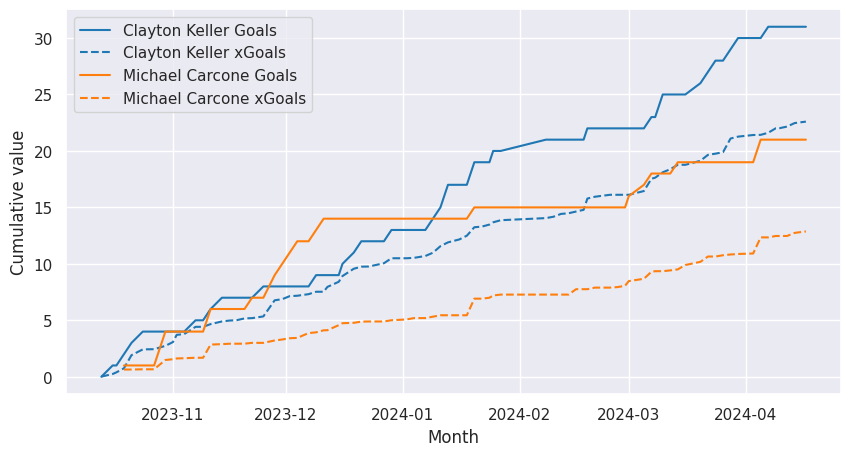

In [25]:
def plot_player_form_during_season_two_players(player_ids: list, season: int) -> None:
    # Initialize an empty DataFrame to store the combined data
    combined_data = pd.DataFrame()

    # Define line styles
    styles = {
        'Goals': '-',
        'xGoals': '--'
    }

    # Define a color cycle
    colors = plt.cm.tab10.colors  # Use the default color map

    # Map player names to colors
    player_colors = {
        player_name: colors[i % len(colors)] 
        for i, player_name in enumerate(players_general_info.loc[player_ids].full_name)
    }

    # Loop through the player IDs to get their data and add it to the combined DataFrame
    for player_id in player_ids:
        player_info = players_general_info.loc[player_id]

        data = (
            df
            .loc[(df.shooting_player_id == player_id) & (df.season == season)]
            .groupby(by=pd.to_datetime(df.game_date))
            .agg(
                g_cnt=("is_goal", "sum"),
                xg_cnt=(f"{MODEL_V}_preds", "sum"),
            )
            .sort_index()
            .cumsum()
            .rename(columns={
                "g_cnt": f"Goals_{player_info.full_name}", 
                "xg_cnt": f"xGoals_{player_info.full_name}"
            })
        )

        # Combine the data for both players and forward fill missing values
        if combined_data.empty:
            combined_data = data
        else:
            combined_data = combined_data.join(data, how='outer').ffill()

    # Plot the combined data with specific colors and styles
    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot each player's goals and xGoals with assigned colors and specified line styles
    for player_name in player_colors.keys():
        player_goals_col = f"Goals_{player_name}"
        player_xg_col = f"xGoals_{player_name}"
        color = player_colors[player_name]

        # Plot goals with solid line
        ax.plot(combined_data.index, combined_data[player_goals_col], 
                label=f"{player_name} Goals", 
                color=color,
                linestyle=styles['Goals'])

        # Plot xGoals with dashed line
        ax.plot(combined_data.index, combined_data[player_xg_col], 
                label=f"{player_name} xGoals", 
                color=color,
                linestyle=styles['xGoals'])
    
    """
    ax.set_title(
        "Cumulative Goals vs. Expected Goals \n"
        f"{players_general_info.loc[player_ids[0]].full_name} and "
        f"{players_general_info.loc[player_ids[1]].full_name} during {season}/{season + 1} season"
    )
    """
    ax.set_xlabel("")
    ax.legend()
    
    ax.set_xlabel("Month")
    ax.set_ylabel("Cumulative value")

    plt.show()
    

plot_player_form_during_season_two_players(player_ids=[8479343, 8479619], season=2023)

#### Break down shot efficiency

In [26]:
def get_player_breakdown_by_dimension(player_id: int, season: int, dim: str) -> pd.DataFrame:
    player_info = players_general_info.loc[player_id]
    
    print(
        f"\033[1mShooting Report by '{dim}': "
        f"{player_info.full_name} ({player_info.position_code}) in {season}/{season + 1} season"
        "\033[0m"
        "\n"
    )
    
    print(
        df
        .loc[(df.shooting_player_id == player_id) & (df.season == season)]
        .groupby(by=dim)
        .agg(
            shots_cnt=("game_id", "count"),
            shoot_perc=("is_goal", "mean"),
            g_cnt=("is_goal", "sum"),
            xg_cnt=(f"{MODEL_V}_preds", "sum"),
        )
        .round(2)
        .assign(
            g_minus_xg=lambda _df: (_df.g_cnt - _df.xg_cnt).round(2),
        )
        .sort_values(by="g_minus_xg", ascending=False)
    )

In [27]:
for player_id in (8479343, 8479619, 8483431, 8477021):
    get_player_breakdown_by_dimension(player_id=player_id, season=SEASON, dim="zone")
    print("\n\n")

Shooting Report by 'zone': Clayton Keller (R) in 2023/2024 season

                shots_cnt  shoot_perc  g_cnt  xg_cnt  g_minus_xg
zone                                                            
low slot               58        0.22     13    6.61        6.39
high slot              48        0.12      6    4.52        1.48
circle                143        0.06      9    8.04        0.96
point                  25        0.08      2    1.49        0.51
other                   3        0.00      0    0.05       -0.05
behind the net          6        0.00      0    0.17       -0.17
blue line              38        0.03      1    1.28       -0.28
neutral                 2        0.00      0    0.43       -0.43



Shooting Report by 'zone': Michael Carcone (L) in 2023/2024 season

                shots_cnt  shoot_perc  g_cnt  xg_cnt  g_minus_xg
zone                                                            
low slot               42        0.21      9    5.64        3.36
circle           

In [28]:
for player_id in (8479343, 8479619, 8483431, 8477021):
    get_player_breakdown_by_dimension(player_id=player_id, season=SEASON, dim="shot_type")
    print("\n\n")

Shooting Report by 'shot_type': Clayton Keller (R) in 2023/2024 season

             shots_cnt  shoot_perc  g_cnt  xg_cnt  g_minus_xg
shot_type                                                    
wrist              174        0.10     18   12.20        5.80
backhand            30        0.13      4    1.71        2.29
slap                79        0.10      8    6.60        1.40
wrap-around          1        0.00      0    0.00        0.00
snap                21        0.05      1    1.07       -0.07
deflected            5        0.00      0    0.39       -0.39
tip-in              13        0.00      0    0.62       -0.62



Shooting Report by 'shot_type': Michael Carcone (L) in 2023/2024 season

             shots_cnt  shoot_perc  g_cnt  xg_cnt  g_minus_xg
shot_type                                                    
wrist               84        0.17     14    7.79        6.21
wrap-around         11        0.09      1    0.08        0.92
backhand            11        0.09      1    0

In [29]:
for player_id in (8479343, 8479619, 8483431, 8477021):
    get_player_breakdown_by_dimension(player_id=player_id, season=SEASON, dim="strength")
    print("\n\n")

Shooting Report by 'strength': Clayton Keller (R) in 2023/2024 season

          shots_cnt  shoot_perc  g_cnt  xg_cnt  g_minus_xg
strength                                                  
5v5             222        0.09     19   14.03        4.97
5v4              77        0.12      9    6.07        2.93
4v4              11        0.18      2    0.82        1.18
5v3               3        0.00      0    0.00        0.00
4v3               5        0.20      1    1.17       -0.17
3v3               5        0.00      0    0.50       -0.50



Shooting Report by 'strength': Michael Carcone (L) in 2023/2024 season

          shots_cnt  shoot_perc  g_cnt  xg_cnt  g_minus_xg
strength                                                  
5v5             134        0.13     18   11.25        6.75
5v4               8        0.12      1    0.44        0.56
4v4               5        0.20      1    0.52        0.48
4v5               3        0.33      1    0.59        0.41
3v4               2        0

In [30]:
def get_players_comparison_by_dimension(season: int, dim: str) -> pd.DataFrame:    
    print(
        f"\033[1mUtah HC Shooting Report by '{dim}' in {season}/{season + 1} season: "
        "\033[0m"
        "\n"
    )
    
    return (
        df
        .loc[(df.shooting_player_id.isin(UHC_PLAYERS)) & (df.season == season)]
        .assign(
            full_name=lambda _df: (_df.shooting_player_id.map(players_general_info.full_name)),
            position_code=lambda _df: (_df.shooting_player_id.map(players_general_info.position_code)),
        )
        .groupby(by=[dim, "full_name", "position_code"])
        .agg(
            shots_cnt=("game_id", "count"),
            shoot_perc=("is_goal", "mean"),
            g_cnt=("is_goal", "sum"),
            xg_cnt=(f"{MODEL_V}_preds", "sum"),
        )
        .query("shots_cnt >= 20")
        .round(2)
        .assign(
            g_minus_xg=lambda _df: (_df.g_cnt - _df.xg_cnt).round(2),
        )
    )

In [31]:
get_players_comparison_by_dimension(season=SEASON, dim="zone")

Utah HC Shooting Report by 'zone' in 2023/2024 season: 



shots_cnt  shoot_perc  g_cnt  \
zone      full_name          position_code                                 
blue line Clayton Keller     R                     38        0.03      1   
          Dylan Guenther     R                     22        0.00      0   
          Ian Cole           D                     77        0.01      1   
          John Marino        D                     43        0.02      1   
          Juuso Valimaki     D                     61        0.02      1   
          Lawson Crouse      L                     33        0.06      2   
          Logan Cooley       C                     31        0.06      2   
          Matias Maccelli    L                     28        0.04      1   
          Michael Carcone    L                     21        0.05      1   
          Michael Kesselring D                     76        0.00      0   
          Mikhail Sergachev  D                     57        0.02      1   
          Nick Bjugstad      C                     29        0.00      0   
          Nick Schmaltz      C                     40        0.02      1   
          Sean Durzi         D                     99        0.04      4   
circle    Alex Kerfoot       C                     32        0.06      2   
          Clayton Keller     R                    143        0.06      9   
          Dylan Guenther     R                     85        0.05      4   
          Juuso Valimaki     D                     28        0.00      0   
          Kevin Stenlund     C                     31        0.06      2   
          Lawson Crouse      L                     51        0.04      2   
          Liam O'Brien       C                     26        0.00      0   
          Logan Cooley       C                     71        0.06      4   
          Matias Maccelli    L                     72        0.04      3   
          Michael Carcone    L                     48        0.12      6   
          Michael Kesselring D                     36        0.08      3   
          Nick Bjugstad      C                     74        0.08      6   
          Nick Schmaltz      C                     76        0.11      8   
          Sean Durzi         D                     41        0.00      0   
high slot Alex Kerfoot       C                     30        0.07      2   
          Barrett Hayton     C                     24        0.04      1   
          Clayton Keller     R                     48        0.12      6   
          Dylan Guenther     R                     36        0.28     10   
          Kevin Stenlund     C                     26        0.12      3   
          Lawson Crouse      L                     65        0.17     11   
          Liam O'Brien       C                     25        0.08      2   
          Logan Cooley       C                     39        0.08      3   
          Matias Maccelli    L                     42        0.12      5   
          Michael Carcone    L                     24        0.17      4   
          Nick Bjugstad      C                     37        0.22      8   
          Nick Schmaltz      C                     61        0.10      6   
          Sean Durzi         D                     29        0.07      2   
low slot  Alex Kerfoot       C                     75        0.11      8   
          Barrett Hayton     C                     46        0.04      2   
          Clayton Keller     R                     58        0.22     13   
          Dylan Guenther     R                     23        0.17      4   
          Jack McBain        C                     44        0.16      7   
          Kevin Stenlund     C                     34        0.12      4   
          Lawson Crouse      L                     63        0.10      6   
          Liam O'Brien       C                     20        0.15      3   
          Logan Cooley       C                     60        0.17     10   
          Matias Maccelli    L                     48        0.12      6   
          Michae

In [32]:
get_players_comparison_by_dimension(season=SEASON, dim="shot_type")

Utah HC Shooting Report by 'shot_type' in 2023/2024 season: 



shots_cnt  shoot_perc  g_cnt  \
shot_type full_name          position_code                                 
backhand  Clayton Keller     R                     30        0.13      4   
          Lawson Crouse      L                     24        0.12      3   
          Nick Bjugstad      C                     21        0.10      2   
slap      Clayton Keller     R                     79        0.10      8   
          Dylan Guenther     R                     20        0.05      1   
          Ian Cole           D                     39        0.00      0   
          Juuso Valimaki     D                     21        0.00      0   
          Lawson Crouse      L                     33        0.09      3   
          Michael Carcone    L                     20        0.10      2   
          Michael Kesselring D                     20        0.00      0   
          Nick Schmaltz      C                     32        0.09      3   
          Sean Durzi         D                     51        0.06      3   
snap      Clayton Keller     R                     21        0.05      1   
          Dylan Guenther     R                     29        0.24      7   
          Juuso Valimaki     D                     20        0.00      0   
          Kevin Stenlund     C                     23        0.04      1   
          Lawson Crouse      L                     30        0.17      5   
          Nick Bjugstad      C                     20        0.20      4   
          Nick Schmaltz      C                     34        0.06      2   
          Sean Durzi         D                     29        0.03      1   
tip-in    Alex Kerfoot       C                     36        0.08      3   
          Barrett Hayton     C                     21        0.10      2   
          Lawson Crouse      L                     28        0.00      0   
          Nick Bjugstad      C                     24        0.04      1   
wrist     Alex Kerfoot       C                     77        0.08      6   
          Barrett Hayton     C                     44        0.02      1   
          Clayton Keller     R                    174        0.10     18   
          Dylan Guenther     R                    105        0.09      9   
          Ian Cole           D                     55        0.04      2   
          Jack McBain        C                     36        0.11      4   
          John Marino        D                     55        0.07      4   
          Juuso Valimaki     D                     60        0.03      2   
          Kevin Stenlund     C                     68        0.10      7   
          Lawson Crouse      L                    104        0.11     11   
          Liam O'Brien       C                     61        0.02      1   
          Logan Cooley       C                    149        0.05      7   
          Matias Maccelli    L                    141        0.09     13   
          Michael Carcone    L                     84        0.17     14   
          Michael Kesselring D                     86        0.06      5   
          Mikhail Sergachev  D                     49        0.00      0   
          Nick Bjugstad      C                    143        0.10     14   
          Nick Schmaltz      C                    135        0.10     14   
          Sean Durzi         D                    100        0.04      4   

                                            xg_cnt  g_minus_xg  
shot_type full_name          position_code                      
backhand  Clayton Keller     R                1.71        2.29  
          Lawson Crouse      L                2.50        0.50  
          Nick Bjugstad      C                2.16       -0.16  
slap      Clayton Keller     R                6.60        1.40  
          Dylan Guenther     R                1.29       -0.29  
          Ian Cole           D                0.36       -0.36  
          Juuso Valimaki     D                0.32       -0.32  
          Lawson Crouse      L        

In [33]:
def get_league_report_by_dimension(dim: str) -> pd.DataFrame:
    return (
        df
        .loc[
            (df.season == SEASON)
        ]
        .groupby(by=[dim])
        .agg(
            shots_cnt=("game_id", "count"),
            shoot_perc=("is_goal", "mean"),
            g_cnt=("is_goal", "sum"),
            xg_cnt=(f"{MODEL_V}_preds", "sum"),
        )
        .round(2)
        .assign(
            g_minus_xg=lambda _df: (_df.g_cnt - _df.xg_cnt).round(2),
            # mape=lambda _df: (_df.g_cnt - _df.xg_cnt).abs().div(_df.g_cnt).mul(100).round(2),
        )
        .sort_values(by="shoot_perc")
    )

In [34]:
get_league_report_by_dimension(dim="zone")

,shots_cnt,shoot_perc,g_cnt,xg_cnt,g_minus_xg
zone,,,,,
other,769,0.01,11,15.41,-4.41
blue line,29896,0.02,716,701.40,14.60
neutral,2033,0.02,32,34.03,-2.03
circle,32568,0.04,1409,1419.52,-10.52
point,4394,0.04,161,158.40,2.60
behind the net,662,0.05,30,39.34,-9.34
high slot,20520,0.11,2262,2050.43,211.57
low slot,28902,0.13,3773,3846.46,-73.46


In [35]:
get_league_report_by_dimension(dim="shot_type")

,shots_cnt,shoot_perc,g_cnt,xg_cnt,g_minus_xg
shot_type,,,,,
slap,14273,0.05,713,690.01,22.99
wrap-around,991,0.06,59,58.95,0.05
wrist,64612,0.06,4072,3923.99,148.01
backhand,8583,0.08,715,731.90,-16.90
deflected,2451,0.08,204,252.56,-48.56
tip-in,10707,0.08,901,943.57,-42.57
snap,17124,0.09,1602,1522.80,79.20
between-legs,82,0.11,9,11.19,-2.19
poke,463,0.12,56,62.62,-6.62


In [36]:
get_league_report_by_dimension(dim="strength")

,shots_cnt,shoot_perc,g_cnt,xg_cnt,g_minus_xg
strength,,,,,
5v5,94456,0.06,5977,5795.65,181.35
3v5,74,0.08,6,6.90,-0.90
4v4,2402,0.08,194,202.14,-8.14
4v5,2546,0.09,241,239.56,1.44
5v4,16652,0.09,1561,1589.88,-28.88
4v3,1095,0.10,109,117.34,-8.34
3v3,1616,0.12,198,188.50,9.50
5v3,713,0.12,84,97.09,-13.09
3v4,190,0.13,24,27.93,-3.93


## Results

- In report.